# Notes on the assignment
Test whether the data is consistent with the theory of beta convergence. Treat $\mathbf{z}_i$ as high-dim.
$$
g_i = \beta y_{i0} + \mathbf{z}_i'\gamma + u_i
$$
$y_{i0}$ is the initial log GDP per capita. The controls are $\mathbf{z}_i$ and $u_i$ is an idiosyncratic error term.
### Tasks
Core tasks:
1. Select regressors, see Overleaf for prioritized list.
2. Insert functions from exercise classes into functions_lasso.py.
3. Estimate model.
4. Construct confidence intervals.
5. Plot results.
6. Tabularize results.

### Workflow
1. Selection of regressors using BRT. Then implement BCCH afterwards, then CV.
    1. Remember standardization of variables (lecture 6 slide 22).
    2. Remember $c$ and $\alpha$ values, taken from BCCH paper. (adjusts rate of converge)
2. Estimate LS
3. Estimate LASSO
4. Estimate post-LASSO
5. Estimate post-double LASSO
6. Estimate post-partialling out LASSO (should be asymptotically equivalent to post-double LASSO selection)


### If time permits
1. Interpolation of missing data (or imputation).
    1. See bonus material under Project 2 on Absalon.

In [93]:
import pandas as pd 
import numpy as np 
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from scipy.stats import norm
import seaborn as sns
# from sklearn.preprocessing import PolynomialFeatures
from functions_lasso import *

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
# Read data
dat = pd.read_csv('growth.csv')
lbldf = pd.read_csv('labels.csv', index_col='variable')
lbl_all = lbldf.label.to_dict() # dictionary of labels: description.

In [181]:
# Variables in dataset, by category.
vv_institutions = ['marketref', 'dem', 'demCGV', 'demBMR', 'demreg'] 
vv_geography = [
        'tropicar','distr', 'distcr', 'distc','suitavg','temp', 'suitgini', 'elevavg', 'elevstd',
        'kgatr', 'precip', 'area', 'abslat', 'cenlong', 'area_ar', 'rough','landlock', 
        'africa',  'asia', 'oceania', 'americas' # 'europe' is the reference
]
vv_geneticdiversity = ['pdiv', 'pdiv_aa', 'pdivhmi', 'pdivhmi_aa']
vv_historical = ['pd1000', 'pd1500', 'pop1000', 'pop1500', 'ln_yst'] # these are often missing: ['pd1', 'pop1']
vv_religion = ['pprotest', 'pcatholic', 'pmuslim']
vv_danger = ['yellow', 'malfal',  'uvdamage']
vv_resources = ['oilres', 'goldm', 'iron', 'silv', 'zinc']
vv_educ = ['ls_bl', 'lh_bl'] # secondary, tertiary: we exclude 'lp_bl' (primary) to avoid rank failure 

vv_all = {'institutions': vv_institutions, 
          'geography': vv_geography, 
          'geneticdiversity': vv_geneticdiversity,
          'historical': vv_historical,
          'religion': vv_religion,
          'danger':vv_danger, 
          'resources':vv_resources
         }
list_of_lists = vv_all.values()
vv_all['all'] = [v for sublist in list_of_lists for v in sublist]

In [199]:
print(dat.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 85 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   code                            214 non-null    object 
 1   marketref                       136 non-null    float64
 2   dem                             155 non-null    float64
 3   demCGV                          150 non-null    float64
 4   demBMR                          154 non-null    float64
 5   demreg                          183 non-null    float64
 6   lp_bl                           143 non-null    float64
 7   ls_bl                           143 non-null    float64
 8   lh_bl                           143 non-null    float64
 9   tropicar                        159 non-null    float64
 10  distcr                          159 non-null    float64
 11  distc                           159 non-null    float64
 12  distr                           159 

In [205]:
# List of all variables
l_all_v = []
for category, varlist in vv_all.items():
    l_all_v += varlist


l_all_v.append("gdp_growth")
l_all_v.append("lgdp_initial")


# 1. Amount of complete observations for all variables = 63:
I = dat[l_all_v].notnull().all(axis=1)
country_index_in_complete_dataset = np.extract(I, dat.index)
# The list of selected variables are of course all variables with atleast non-empty columns.




# Amount of observations with complete data for gdp_growth and lgdp_initial = 109:
# 1. I = True and false index for complete cases of gdp_growth and lgdp_initial
I = dat[['gdp_growth', 'lgdp_initial']].notnull().all(axis=1)

# 2. The variables that have complete data for these observations
I_each = {}
for v in l_all_v:
    I_v = dat.loc[I, v].notnull()
    I_each[v] = I_v
# 3. The list of selected variables with complete data for these observations;
# ['area', 'cenlong', 'africa', 'asia', 'oceania', 'americas', 'pdiv',
#  'pprotest', 'pcatholic', 'pmuslim', 'uvdamage', 'gdp_growth', 'lgdp_initial']
selected_vars = []
for key in I_each.keys():
    if I_each[key].all():
        selected_vars.append(key)


In [206]:
# Data cleaning and adding controls
zs_common_control = ['pop_growth', 'investment_rate']
zs_uncommon_control = vv_all['geography'] + vv_all['danger'] + vv_all['resources'] #+ vv_all['religion']  + ['dem'] + ['demCGV'] + ['demBMR']
zs = zs_common_control + zs_uncommon_control

ds = ['lgdp_initial']
ys = ['gdp_growth']
xs = ds + zs
all_vars = ['gdp_growth'] + xs

# Filter missing data
I = dat[all_vars].notnull().all(axis=1)
Z = dat.loc[I, zs].to_numpy()



D = dat.loc[I, ds].to_numpy()
# Note is the full matrix collection of variables of D and Z.
X = dat.loc[I, xs].to_numpy() 
y = dat.loc[I, ys].to_numpy() * 100

# Standardize all variables (so no need for constant terms)
Z_std = standardize(Z)
D_std = standardize(D)
X_std = standardize(X)
y_std = standardize(y)
print(Z.shape)
# Check full rank
K = X_std.shape[1]
assert np.linalg.matrix_rank(X_std) == X_std.shape[1], f'X does not have full rank'

(88, 31)


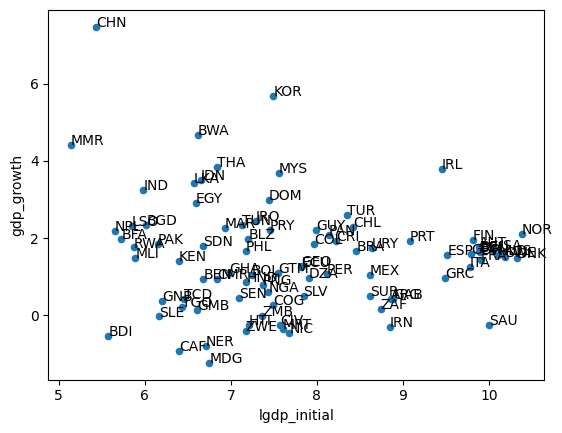

In [207]:
# Plot for selected countries.
country_code = dat.loc[I, 'code'] # country code for I criterion.
# print(country_code.shape[0] == X.shape[0]) # dimension check

data_selected = pd.DataFrame(X, columns=xs, index=country_code)

y_df = pd.DataFrame(y, columns=['gdp_growth'], index=country_code)
data_final = pd.concat([y_df, data_selected], axis=1)

ax_data = data_final.plot.scatter(x='lgdp_initial', y='gdp_growth')
for idx, row in data_final.iterrows():
    ax_data.annotate(idx, (row['lgdp_initial'], row['gdp_growth']))

#### Model estimates, for OLS, PSL, PDL, PPL.
Penalties CV, BRT and BCCH are applied for LASSO based methods.

In [208]:
# OLS estimation
# OLS without controls
X_no_control = D_std
beta_hat = np.linalg.inv(X_no_control.T @ X_no_control) @ X_no_control.T @ y_std
print("OLS without controls:", beta_hat[0][0].round(5))

# OLS with all controls
X_with_control = X_std
beta_hat = np.linalg.inv(X_with_control.T @ X_with_control) @ X_with_control.T @ y_std
dict_beta = dict(zip(xs, beta_hat.flatten()))
print("OLS with all controls:")
for key, estimate in dict_beta.items():
    print(f"  {key}: {estimate.round(5)}")

OLS without controls: -0.11585
OLS with all controls:
  lgdp_initial: -1.20145
  pop_growth: 0.13396
  investment_rate: 0.21949
  tropicar: 0.44261
  distr: -0.29686
  distcr: 0.37882
  distc: -0.54992
  suitavg: -0.10259
  temp: -0.5044
  suitgini: -0.1576
  elevavg: -0.41832
  elevstd: 0.05666
  kgatr: -0.11176
  precip: -0.48364
  area: 0.31473
  abslat: -1.24141
  cenlong: 0.76507
  area_ar: -0.17037
  rough: 0.08615
  landlock: 0.19751
  africa: -0.46806
  asia: -0.26079
  oceania: -0.06255
  americas: 0.29816
  yellow: 0.0948
  malfal: -0.68399
  uvdamage: -1.39897
  oilres: 0.03139
  goldm: 0.06785
  iron: -0.07495
  silv: 0.01686
  zinc: 0.21472


##### CV, BRT and BCCH penalties

In [209]:
# Function for string output for selected variables.
def get_selected_var(selected_variables):
    xs_selected = []
    for i in range(0,len(selected_variables)):
        if selected_variables[i] == True:
            xs_selected.append(i)
    xs_varname = []

    for var_index in xs_selected:
        xs_varname.append(xs[var_index])

    return xs_varname

In [210]:
# Penalty grid for Lasso.
penalty_grid = np.geomspace(start=0.001, stop=100, num=50)

In [211]:
# Lasso with CV, five folds:
fit_CV = LassoCV(alphas=penalty_grid, fit_intercept=False, cv=5, max_iter=10000).fit(X_std, y_std.reshape(-1,))
penalty_CV = fit_CV.alpha_
coefs_CV = fit_CV.coef_
selected_variables_CV = (coefs_CV != 0)
print("Selected variables with Lasso CV penalty:", get_selected_var(selected_variables_CV))

# Lasso with BRT penalty:
penalty_BRT = BRT(X_tilde=X_std, y=y_std)
fit_BRT = Lasso(alpha=penalty_BRT, fit_intercept=False, max_iter=10000).fit(X_std, y_std.reshape(-1,))
coefs_BRT = fit_BRT.coef_
selected_variables_BRT = (coefs_BRT != 0)
print("Selected variables with Lasso BRT penalty:", get_selected_var(selected_variables_BRT))

# Lasso with BCCH penalty:
penalty_BCCH = BCCH(X_tilde=X_std, y=y_std)
fit_BCCH = Lasso(alpha=penalty_BCCH, fit_intercept=False, max_iter=10000).fit(X_std, y_std.reshape(-1,))
coefs_BCCH = fit_BCCH.coef_
selected_variables_BCCH = (coefs_BCCH != 0)
print("Selected variables with Lasso BCCH penalty:", get_selected_var(selected_variables_BCCH))


Selected variables with Lasso CV penalty: ['lgdp_initial', 'pop_growth', 'investment_rate', 'tropicar', 'distr', 'temp', 'suitgini', 'elevavg', 'area', 'cenlong', 'rough', 'landlock', 'africa', 'oceania', 'malfal', 'oilres', 'goldm', 'zinc']
Selected variables with Lasso BRT penalty: ['asia', 'malfal']
Selected variables with Lasso BCCH penalty: []


##### LASSO path

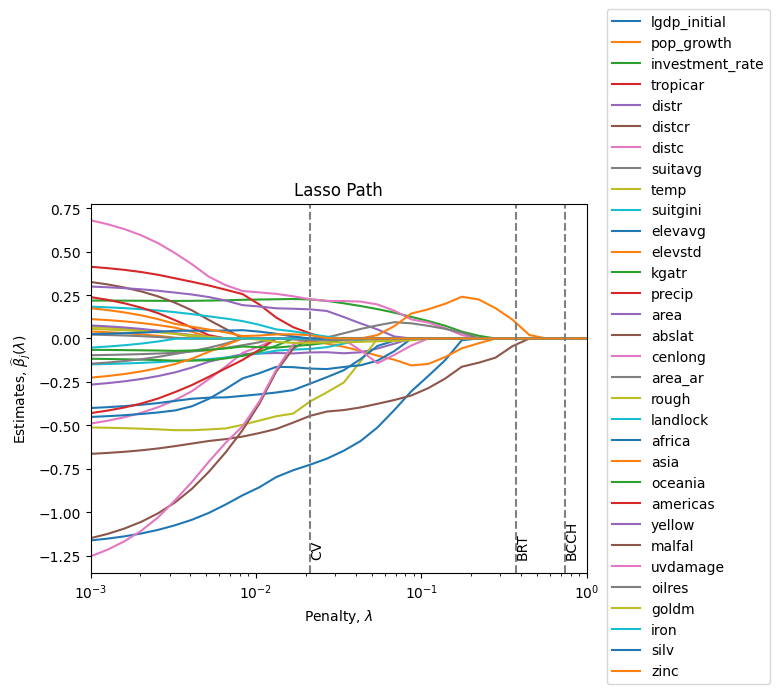

In [212]:
# Coefficients for Lasso path
coefs = []
for penal in penalty_grid:
    fit = Lasso(alpha=penal, fit_intercept=False, max_iter=10000).fit(X_std, y_std)
    coefs.append(fit.coef_)

# Plot Lasso path
plot_lasso_path(penalty_grid=penalty_grid, coefs=coefs, legends=xs, vlines={'BCCH':penalty_BCCH,'BRT':penalty_BRT, 'CV':penalty_CV})

#### OLS for Post LASSO methods

##### Post single LASSO:

In [213]:
# Function that checks if D_std needs to be stacked with Z_arr for post-lasso OLS
# If D_std is already in Z_arr, then stacking D_std again breaks rank condition.
def should_i_stack_or_should_i_not(Z_arr, selected_variables, D=D):
    if Z_arr.shape[1] == 0:
        return D
    elif selected_variables[0] == True:
        return Z_arr
    else:
        return (np.column_stack((D, Z_arr)))


# PSL
CV_Z_J = X[:, selected_variables_CV] # Remember: Use non-standardized X for OLS
BRT_Z_J = X[:, selected_variables_BRT]
BCCH_Z_J = X[:, selected_variables_BCCH]
CV_X_J = should_i_stack_or_should_i_not(CV_Z_J, selected_variables_CV)
BRT_X_J = should_i_stack_or_should_i_not(BRT_Z_J, selected_variables_BRT)
BCCH_X_J = should_i_stack_or_should_i_not(BCCH_Z_J, selected_variables_BCCH)

# Add constant term
CV_X_J = np.column_stack((CV_X_J, np.ones((CV_X_J.shape[0],1))))
BRT_X_J = np.column_stack((BRT_X_J, np.ones((BRT_X_J.shape[0],1))))
BCCH_X_J = np.column_stack((BCCH_X_J, np.ones((BCCH_X_J.shape[0],1))))

# OLS estimation for Post Lasso.
CV_coefs_PSL = np.linalg.inv(CV_X_J.T @ CV_X_J) @ CV_X_J.T @ y
BRT_coefs_PSL = np.linalg.inv(BRT_X_J.T @ BRT_X_J) @ BRT_X_J.T @ y
BCCH_coefs_PSL = np.linalg.inv(BCCH_X_J.T @ BCCH_X_J) @ BCCH_X_J.T @ y
print("Post Lasso estimates:")
print("  CV:", CV_coefs_PSL[0].round(5))
print("  BRT:", BRT_coefs_PSL[0].round(5))
print("  BCCH:", BCCH_coefs_PSL[0].round(5))

Post Lasso estimates:
  CV: [-0.89568]
  BRT: [-0.39281]
  BCCH: [-0.12093]


##### Post Double Lasso:

In [214]:
fit = LassoCV(alphas=penalty_grid, cv=5, max_iter=10000).fit(Z_std, D.reshape(-1,))
coefs_Z_D = fit.coef_
prediction = fit.predict(Z_std)


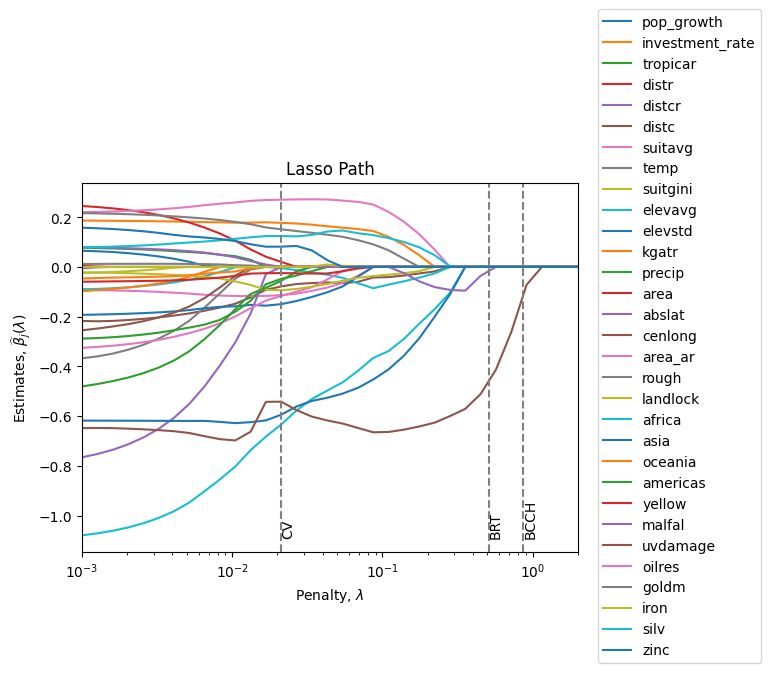

-0.909
Double Lasso estimates:
  CV: -0.17239
  BRT: -0.26205
  BCCH: -0.15201


In [223]:
# Step 1: Lasso D on Z
coefs = []
for penal in penalty_grid:
    fit = Lasso(alpha=penal, fit_intercept=False, max_iter=10000).fit(Z_std, D)
    coefs.append(fit.coef_)



fit_D_on_Z_CV = LassoCV(alphas=penalty_grid, cv=5, max_iter=10000).fit(Z_std, D.reshape(-1,))
fit_D_on_Z_BRT = Lasso(alpha=BRT(Z_std, D), max_iter=10000).fit(Z_std, D.reshape(-1,))
fit_D_on_Z_BCCH = Lasso(alpha=BCCH(Z_std, D), max_iter=10000).fit(Z_std, D.reshape(-1,))

plot_lasso_path(penalty_grid=penalty_grid, coefs=coefs, legends=zs,
                vlines={'BCCH':BCCH(Z_std, D),'BRT':BRT(Z_std, D), 'CV':penalty_CV})


# Get selected variables
coefs_D_on_Z_CV = fit_D_on_Z_CV.coef_
selected_vars_Z_CV = (coefs_D_on_Z_CV != 0)
coefs_D_on_Z_BRT = fit_D_on_Z_BRT.coef_
selected_vars_Z_BRT = (coefs_D_on_Z_BRT != 0)
coefs_D_on_Z_BCCH = fit_D_on_Z_BCCH.coef_
selected_vars_Z_BCCH = (coefs_D_on_Z_BCCH != 0)
# print("Selected vars 1. stage, CV penalty:", get_selected_var(selected_vars_Z_CV))
# print("Selected vars 1. stage, BRT penalty:", get_selected_var(selected_vars_Z_BRT))
# print("Selected vars 1. stage, BCCH penalty:", get_selected_var(selected_vars_Z_BCCH))

# Residuals for step 1.
res_D_Z_CV = D - fit_D_on_Z_CV.predict(Z_std).reshape(-1,1)
res_D_Z_BRT = D - fit_D_on_Z_BRT.predict(Z_std).reshape(-1,1)
res_D_Z_BCCH = D - fit_D_on_Z_BCCH.predict(Z_std).reshape(-1,1)

# Step 2: Lasso Y on Z (and D)
fit_Y_on_Z_D_CV = LassoCV(alphas=penalty_grid, cv=5, max_iter=10000).fit(X_std, y.reshape(-1,))
fit_Y_on_Z_D_BRT = Lasso(alpha=BRT(X_tilde=X_std, y=y), max_iter=10000).fit(X_std, y.reshape(-1,))
fit_Y_on_Z_D_BCCH = Lasso(alpha=BCCH(X_tilde=X_std, y=y), max_iter=10000).fit(X_std, y.reshape(-1,))

# Get selected variables
coefs_Y_on_Z_D_CV = fit_Y_on_Z_D_CV.coef_
selected_vars_Y_Z_D_CV = (coefs_Y_on_Z_D_CV != 0)
# Z_J_CV = Z[:, coefs_Y_on_Z_D_CV != 0]
# coefs_Y_on_Z_D_BRT = fit_Y_on_Z_D_BRT.coef_
# selected_vars_Y_Z_D_BRT = (coefs_Y_on_Z_D_BRT != 0)
# coefs_Y_on_Z_D_BCCH = fit_Y_on_Z_D_BCCH.coef_
# selected_vars_Y_Z_D_BCCH = (coefs_Y_on_Z_D_BCCH != 0)
# print("Selected vars 2. stage, CV penalty:", get_selected_var(selected_vars_Y_Z_D_CV))
# print("Selected vars 2. stage, BRT penalty:", get_selected_var(selected_vars_Y_Z_D_BRT))
# print("Selected vars 2. stage, BCCH penalty:", get_selected_var(selected_vars_Y_Z_D_BCCH))

# Residuals for step 2.
res_Y_Z_D_CV = y - fit_Y_on_Z_D_CV.predict(X_std).reshape(-1,1)
res_Y_Z_D_BRT = y - fit_Y_on_Z_D_BRT.predict(X_std).reshape(-1,1)
res_Y_Z_D_BCCH = y - fit_Y_on_Z_D_BCCH.predict(X_std).reshape(-1,1)

# Step 3: OLS estimates
# Get union of selected variables from both stages, and sort so lgdp_initial is first.
selected_vars_union_CV = np.union1d(get_selected_var(selected_vars_Z_CV), get_selected_var(selected_vars_Y_Z_D_CV))
selected_vars_union_CV = np.delete(selected_vars_union_CV, np.where(selected_vars_union_CV == 'lgdp_initial'))
# selected_vars_union_CV = np.append(selected_vars_union_CV, ['lgdp_initial'])[::-1]


# OLS:
OLS_CV_X = dat.loc[I, selected_vars_union_CV].to_numpy()
OLS_CV_X = np.column_stack((D, OLS_CV_X, np.ones((OLS_CV_X.shape[0],1))))
coefs_OLS_CV = np.linalg.inv(OLS_CV_X.T @ OLS_CV_X) @ OLS_CV_X.T @ y
print(coefs_OLS_CV[0][0].round(5))


alpha_PDL_CV = (res_D_Z_CV.T @ res_Y_Z_D_CV) / (res_D_Z_CV.T @ D)   
alpha_PDL_BRT = (res_D_Z_BRT.T @ res_Y_Z_D_BRT) / (res_D_Z_BRT.T @ D)
alpha_PDL_BCCH = (res_D_Z_BCCH.T @ res_Y_Z_D_BCCH) / (res_D_Z_BCCH.T @ D)

print("Double Lasso estimates:")
print("  CV:", alpha_PDL_CV[0][0].round(5))
print("  BRT:", alpha_PDL_BRT[0][0].round(5))
print("  BCCH:", alpha_PDL_BCCH[0][0].round(5))

In [ ]:
# PPOL, Post Partialling Out Lasso
# Penalties
